## Imports

In [183]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pycountry
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
import pingouin as pg
import numpy as np
import seaborn as sns
# import warnings

# warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
np.random.seed(42)

## Functions

In [58]:
def read_ppp() -> pd.DataFrame:
    """
    Reads PPP csv and returns resulting data frame
    Data Manipulations:
    - Only use years since we're not going to use anything before unless we go historic route
    - Fill nans with string type Null
    - - thought process is to us other functions that will detect str type and throw an error
    - - if nan operation will probably go through, so doing isinstance == str would be best probably
    - Also index columns are the country code, should match to the PyCountry library
    
    Inputs: None
    Output: pd.DataFrame
    """
    years = ["2019", "2020", "2021", "2022"]
    ppp = pd.read_csv("data/ppp.csv", header=2, index_col="Country Code")[years]
    # ppp = ppp.fillna("Null") # this way we can control the type, so we can create a function that checks type before anything else
    return ppp

In [59]:
def walrus_helper(salaries: pd.DataFrame) -> dict:
    """
    Helper function that is just a for loop that goes through unique job titles and assigns a basic name

    Input: pd.DataFrame
    Output: dict{str: str}
    """
    mapping = {}
    for job in list(salaries["job_title"].unique()):
        if (short := "Analyst") in job:
            mapping[job] = short.lower()
    
        elif (short := "Engineer") in job:
            mapping[job] = short.lower() + "_other"
            
        elif (short := "Data Scientist") in job or "Data Science" in job:
                mapping[job] = '_'.join(short.lower().split(" "))
            
        elif "Architect" in job:
            mapping[job] = "systems_architect"
    
        elif "Manager" in job:
            mapping[job] = "management"
    
        elif (short := "Developer") in job:
            mapping[job] = short.lower()
            
        elif "math" in job.lower() or "stat" in job.lower():
            mapping[job] = "mathematician_statistician"
            
        else:
            mapping[job] = "scientist_other"
    return mapping

In [60]:
def read_salaries() -> pd.DataFrame:
    """
    Reads the salaries from ai-net and returns them into a dataframe
    Data Manipulation:
    - Change 2 letter country names into 3 letter names for uniformity
    - Map above function in job_title to simpler names
    - Only taking 2020 - 2023, we have no data on 2024
    
    Input: None
    Output: pd.DataFrame
    """
    salaries = pd.read_csv("data/salaries.csv")
    country_abbreviations = {country.alpha_2: country.alpha_3 for country in pycountry.countries}
    mapping = walrus_helper(salaries)
    
    salaries[["employee_residence", "company_location"]] = salaries[["employee_residence", "company_location"]].replace(country_abbreviations)
    salaries["job_title"] = salaries["job_title"].replace(mapping)
    salaries = salaries[salaries["work_year"] < 2024]
    
    return salaries

In [61]:
def create_onehot_skills(frames: dict) -> None:
    """
    Given a dictionary of pandas dataframes we want to one hot the skills in particular.
    We want to take the skills in the different columns and one hot them such we can sum them for groupby operations.
    We get a dictionary of pandas DataFrames and perform an inplace operation such that we don't have to create new memory.
    Return a dictionary of a list of strings for a couple reasons:
        - there's no way we will remember all of these so automation by putting these into a list seemed like the best idea
        - the keys will match those in the input in case we want to do something with these later per year
        - hashing onto a dictionary should allow for ease of access since no 2 years will have the same EXACT one hot columns, hence the list
    The above is deprecated, after merging with similar columns these will all be useless to us

    We also drop the _Empty for EVERYTHING since that information is useless to us
    
    Input: frames dict{str: pd.DataFrames}
    Ouput: None

    https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list

    Rough example flow of function for one sample:
    C; C++; Perl -> [C, C++, Perl] -> [1, 1, 1, 0]
    Python       -> [Python]       -> [0, 0, 0, 1]
    """
    # some constants
    standard = [("language", "lg"), ("database", "db"), ("platform", "pf"), ("webframe", "wf"), ("misctech", "mt")]
    status = [("wanttoworkwith", "www"), ("haveworkedwith", "hww")]
    
    for key, frame in frames.items():
        new_cols = []
        for stan, abv in standard:
            for stat, abr in status:
                coi = stan + stat # coi = column of interest
                abbr = abv + abr + "_"
                mlb = MultiLabelBinarizer(sparse_output=True) # saves ram
                frame[coi] = frame[coi].str.split(";")
                transformed = mlb.fit_transform(frame.pop(coi))
                new_cois = [abbr + name for name in mlb.classes_]
                frame = frame.join(
                            pd.DataFrame.sparse.from_spmatrix(
                                transformed,
                                index=frame.index,
                                columns=new_cois
                            )
                        )
                new_cois.remove(abbr + "Empty")
                new_cols += new_cois
                frame = frame.drop(abbr + "Empty", axis=1)
        # this needs to be here, if not throse Sparse type errors
        # # Sparse types don't allow normal groupby operations (ie reshape) so we need to turn them into ints
        # # int8 don't take up a ton and it's just 0's and 1's
        # # for all intents and purposes these are sparse matrices, we just want to avoid the object
        frame[new_cols] = frame[new_cols].fillna(0)
        frame[new_cols] = frame[new_cols].astype('int8')
        frames[key] = frame

In [62]:
def abbr_education(frames: dict) -> None:
    """
    Similar in spirit to the other one hots, but this is in place
    Automatically abbreviates education levels across all frames
    Had to hard code the list again, not a big deal only 8 items
    
    Input: frames dict{str: pd.DataFrames}
    Ouput: None
    """
    # more hardcoded stuff that are needed
    abbreviations = ["Associate's", "Bachelor's", "Master's", "Elementary", "Professional", "Secondary", "Some College", "Else"]
    
    for key, frame in frames.items():
        # easier to replace this, makes it much easier to work with
        frame['edlevel'] = frame['edlevel'].replace({'I never completed any formal education': 'Something else'})

        # need the sorted since they have the same rough scheme
        levels = list(frame['edlevel'].unique())
        levels.sort()
        o = 0 # offset

        # dictionary to feed into repalce function
        replace_dict = {}
        for i in range(len(levels)):
            col = levels[i]
            if col == 'nan':
                break
            abbr = abbreviations[i-o]
            if 'doctoral' in col:
                replace_dict[col] = "Doctoral"
                o += 1
                continue
            replace_dict[col] = abbr
                
        frame['edlevel'] = frame['edlevel'].replace(replace_dict)
        frames[key] = frame

In [63]:
def bin_ages(frames: dict) -> None:
    """
    Bin ages so that they match with the later year surveys
    """
    bins = [0, 18, 24, 34, 44, 54, 64, 100]
    labels = ['Under 18 years old', '18-24 years old', '25-34 years old', '35-44 years old', '45-54 years old', '55-64 years old', '65 years or older']
    for year, frame in frames.items():    
        if frame["age"].dtypes == float:
            frame["age"] = pd.cut(frame["age"], bins=bins, labels=labels)
        frame["age"] = frame["age"].astype('str')
        
        frames[year] = frame

In [64]:
def find_similar_col(frames) -> list:
    """
    Returns the set of columns that the all share, ideally we maximize the ratio of this to merge.
    """
    union = []
    for key, frame in frames.items():
        union.append(set(frame.columns))
        
    standard = union[0]
    for cols in union[1:]:
        standard = standard.intersection(cols)
    return list(standard)

In [65]:
def encode_devtype(df: pd.DataFrame) -> (pd.DataFrame, list):
    """
    Standardizing DevType so that we can merge on ai-net data
    """
    def map_job(category_list) -> list:
        devtype = set()
        for category in category_list:
            if (clean := "data scientist") in category.lower():
                devtype.add(clean)
            elif "math" in category.lower() or "stat" in category.lower():
                devtype.add("mathematician_statistician")
            elif (clean := "analyst") in category.lower():
                devtype.add(clean)
            elif (clean := "manage") in category.lower():
                devtype.add(clean + "ment")
            elif (clean := "scientist") in category.lower():
                devtype.add(clean + "_other")
            elif (clean := "engineer") in category.lower():
                devtype.add(clean + "_other")
            elif (clean := "developer") in category.lower():
                devtype.add(clean)
            else:
                devtype.add("systems_architect")
        return list(devtype)
        
    coi = "devtype"
    mlb = MultiLabelBinarizer(sparse_output=True) # saves ram
    df[coi] = df[coi].str.split(";")
    df[coi] = df[coi].apply(map_job)
    transformed = mlb.fit_transform(df.pop(coi))
    new_cols = mlb.classes_
    df = df.join(
                pd.DataFrame.sparse.from_spmatrix(
                    transformed,
                    index=df.index,
                    columns=mlb.classes_
                )
            )
    # see above binarizer
    df[new_cols] = df[new_cols].fillna(0)
    df[new_cols] = df[new_cols].astype('int8')
    return df, new_cols

In [66]:
def read_stackoverflow() -> (pd.DataFrame, list, list):
    """
    Reads CSVs and gets the numbe of data professionals. Any empty values are dropped from job title and 
    salary so we will always have data. Other columns may have nans.
    Data Manipulation:
    - dropping nans from salary and devtype combined
    - Changing the salary column to ConvertedCompYearly so we can merge all data frames comes time
    - Lowering column names since there was some weird camel case going on
    - Converting specific columns that mean the same thing per year into a singular name
    - Fill in nans for language/skill specific values with "nan"
      - this is so we can one hot later on for a more concise analysis, more later on
    - Binarize the different skills per year, see create_onehot_skills
    - Next we abbreviate education levels so that we can also one hot them, see above
    - Change education to keep into one column binarizing doesn't make any sense
    - Changing org size into something much more manageable, mainly the I don't know field
    - We merge them into one, the same groupby operations can still be done as if seperate
    - Encode devtype to binarize as well since it's very difficult to parse through ; every single time
        - we can do some clever work arounds
    - Lastly we return the skills columns really quick to save headache later on

    Inputs: Nothing
    Outputs: tuple(pd.DataFrame, list[str], list[str])
    """
    country_abbreviations_1 = {country.name: country.alpha_3 for country in pycountry.countries}
    country_abbreviations_2 = {country.official_name: country.alpha_3 for country in pycountry.countries}
    frames = {}
    stack_o_files = os.listdir("data/stack_overflow/")
    for file in stack_o_files:
        year = file[-8:-4]
        df = pd.read_csv(f"data/stack_overflow/{file}", encoding='ISO-8859-1')

        # standardize compensation columns
        if 'ConvertedComp' in df.columns:
            df = df.rename(columns={'ConvertedComp': 'ConvertedCompYearly'})

        # standardize some columns
        # using camel case resulted in errors with webframe where sometimes F was capitalized
        standard = ["language", "database", "platform", "webframe", "misctech"]
        df.columns = df.columns.str.lower()
        for stan in standard:
            if f"{stan}workedwith" in df.columns:
                df = df.rename(columns={f'{stan}workedwith': f'{stan}haveworkedwith', f'{stan}desirenextyear':f'{stan}wanttoworkwith'})
            df[f"{stan}haveworkedwith"] = df[f"{stan}haveworkedwith"].fillna(value="Empty")
            df[f"{stan}wanttoworkwith"] = df[f"{stan}wanttoworkwith"].fillna(value="Empty")

        # standardize some country names, now they should match with Kaggle dataset
        df["country"] = df["country"].replace(country_abbreviations_1)
        df["country"] = df["country"].replace(country_abbreviations_2)

        # we have some numbers so we can't just do entire df
        df[['edlevel', 'orgsize']] = df[['edlevel', 'orgsize']].fillna(value="nan")
        df['orgsize'] = df['orgsize'].replace({'I donâ\x80\x99t know': 'IDK'})
        
        df = df.dropna(subset=["devtype", "convertedcompyearly"])
        df = df[df["devtype"].str.contains("data", case=False)]
        df["count"] = [1] * len(df) # this is for our groupby so that we can say count > cull when we sum or count
        df["year"] = [year] * len(df)
        frames[f"df_data_{year}"] = df

    # oops forgot indentation
    abbr_education(frames)
    bin_ages(frames)
    create_onehot_skills(frames)
    similar = find_similar_col(frames)
    
    # finally going to standardize to merge devtypes
    for key, frame in frames.items():
        frames[key] = frame[similar]
    df = pd.concat([frame for key, frame in frames.items()], axis=0)
    df, employment = encode_devtype(df)
    skills = [col for col in df.columns if any(substr in col for substr in ['lg', 'db', 'pf', 'wf', 'mt'])]
    return df, skills, employment

## Reading (Run Once)

In [67]:
stack_overflow, skills_list, employments = read_stackoverflow()
ppp = read_ppp()
salaries = read_salaries()

C:\Users\luism\anaconda3\envs\milestone_1\Lib\site-packages\pycountry\db.py:51: UserWarning: Country's official_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)


## Analysis

In [82]:
# more workable until we go by skills
s_o = stack_overflow.drop(skills_list, axis=1)
list(s_o.columns)

['yearscode',
 'edlevel',
 'comptotal',
 'country',
 'employment',
 'convertedcompyearly',
 'mainbranch',
 'sopartfreq',
 'sovisitfreq',
 'age',
 'soaccount',
 'year',
 'yearscodepro',
 'count',
 'socomm',
 'surveyease',
 'orgsize',
 'surveylength',
 'analyst',
 'data scientist',
 'developer',
 'engineer_other',
 'management',
 'scientist_other',
 'systems_architect']

In [69]:
salaries.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

### Descriptive Statistics

### One Way ANOVA on Location and Comp Salary

#### Helper Functions

In [156]:
def get_similar_countries(df: pd.DataFrame, want: int = 10) -> list:
    """
    Get the number of countries that we want so we can index for ANOVA
    Consistent across the years for a good comparison
    """
    groupped = df.groupby('year')
    loc_list = list()
    head = 1
    
    while len(loc_list) < want:
        loc_set = set()
        for year, frame in groupped:
            grouped = frame.groupby("country").size().sort_values(ascending=False)
            if not loc_set:
                loc_set = set(grouped.head(head).index)
                continue
            temp_set = set(grouped.head(head).index)
            loc_set = loc_set.intersection(temp_set)
        loc_list = list(loc_set)
        head += 1
    return loc_list

#### ANOVA

In [157]:
loc_so = s_o[["year", "country", "convertedcompyearly"]]
loc_so.loc[:, "year"] = loc_so.loc[:, "year"].astype('int64')

loc_sal = salaries[["work_year", "employee_residence", "salary_in_usd"]]
loc_sal.loc[:, "salary_in_usd"] = loc_sal.loc[:, "salary_in_usd"].astype("float64")
loc_sal.columns = loc_so.columns


location = pd.concat([loc_so, loc_sal], ignore_index=True)
location
loc_so.dtypes, loc_sal.dtypes

(year                    object
 country                 object
 convertedcompyearly    float64
 dtype: object,
 year                    int64
 country                object
 convertedcompyearly     int64
 dtype: object)

In [213]:
countries = get_similar_countries(location, 20)

In [214]:
for year, frame in groupped:
    print(year)
    frame = frame[frame["country"].isin(countries)]
    aov = pg.anova(data=frame, dv="convertedcompyearly", between="country", detailed=True)
    display(aov)

2019


,Source,SS,DF,MS,F,p-unc,np2
0,country,1.044744e+14,19,5.498651e+12,51.971066,6.123095e-190,0.069654
1,Within,1.395425e+15,13189,1.058022e+11,NaN,NaN,NaN


2020


,Source,SS,DF,MS,F,p-unc,np2
0,country,4.377320e+13,19,2.303853e+12,34.972102,1.331925e-123,0.071909
1,Within,5.649601e+14,8576,6.587688e+10,NaN,NaN,NaN


2021


,Source,SS,DF,MS,F,p-unc,np2
0,country,4.776961e+13,19,2.514190e+12,14.355395,3.937604e-46,0.027638
1,Within,1.680634e+15,9596,1.751390e+11,NaN,NaN,NaN


2022


,Source,SS,DF,MS,F,p-unc,np2
0,country,8.976899e+13,19,4.724684e+12,6.682907,7.586757e-18,0.013915
1,Within,6.361409e+15,8998,7.069803e+11,NaN,NaN,NaN


2023


,Source,SS,DF,MS,F,p-unc,np2
0,country,1.271251e+13,19,6.690794e+11,55.024831,4.765940e-200,0.085467
1,Within,1.360293e+14,11187,1.215959e+10,NaN,NaN,NaN


### T-Tests On Salary if Needed

In [215]:
dfs = []
for year, frame in groupped:
    t_tests = np.zeros((len(countries), len(countries)))
    frame = frame[frame["country"].isin(countries)]
    for i in range(len(countries)):
        control = countries[i]
        for j in range(i+1, len(countries)):
            exp = countries[j]
            d1 = frame[frame["country"] == control]
            d2 = frame[frame["country"] == exp]
            result = pg.ttest(d1.convertedcompyearly, d2.convertedcompyearly).round(3)
            t_tests[j, i] = result.loc["T-test", "p-val"]
    df = pd.DataFrame(t_tests, columns=countries, index=countries)
    dfs.append(df)

C:\Users\luism\anaconda3\envs\milestone_1\Lib\site-packages\pingouin\bayesian.py:152: RuntimeWarning: divide by zero encountered in scalar divide
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)
C:\Users\luism\anaconda3\envs\milestone_1\Lib\site-packages\pingouin\bayesian.py:152: RuntimeWarning: divide by zero encountered in scalar divide
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


5


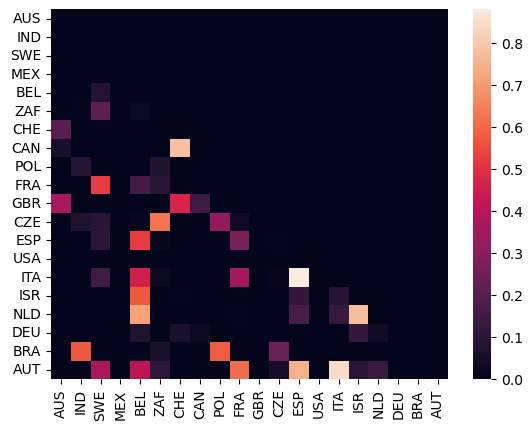

In [220]:
print(len(dfs))
# not a heatmap for value
# is everything kind of moving? do relationships stay throughout the years?
# # better visualization?
# fabricated metric? see correlation between the years
# # comprehensive view of this
# heatmap works for all the years into a single metric with the heat map
# growth rate between year
# collapse data set and get deltas from start to end
# # in between years and see correlations between growth
sns.heatmap(dfs[0]);

### One Way ANOVA on Degree

In [ ]:
# anova

### One Way ANOVA on Experience

### One Way ANOVA on Location

### One Way ANOVA on Year

### Salary Skew Overall

### Identify any outliers

Whats the story on the outliers?
- is it an outlier that started a trend and we see more?
- is it an oddity?

Hiking analogy
- go high level, then take a step down and keep going down
- go onto the next subject
- like for us go down to specific countries and specific analysis
- not only for the narrative, but what the data can tell us

## Charts

### Choropleth Chart on Salary by Location (need)

### Line Chart of Salary by Location (need)

### Blox Plot of a Country to Show Skew if Any (need)

### Histogram of Countries with Highest Response Rates (need)

### Sunburst Plot (want)